In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.linalg import lstsq

import jlinops

In [2]:
# def cgls(A, b, x0=None, maxiter=None, return_search_vectors=False, 
#          return_iterates=False, tol=1e-3, relative=True, early_stopping=False):
#     """CGLS method applied to solution of
#     min_x || A x - b ||_2.
#     """
    
#     device = A.device
#     xp = jlinops.get_module(b)
#     n = A.shape[1]
    
#     # Initialization
#     if x0 is None:
#         x = xp.zeros(n)
#     else:
#         x = x0
        
#     # Maxiter
#     if maxiter is None:
#         maxiter = n
    
#     r_prev = b - A.matvec(x)
#     At_r_prev = A.rmatvec(r_prev)
#     d = A.rmatvec(r_prev)
    
#     init_residual_norm = xp.linalg.norm(r_prev)
#     residual_norms = [init_residual_norm]
#     x_norms = [xp.linalg.norm(x)]
#     n_iters = 0
    
#     if return_search_vectors:
#         search_vectors = [d]
#     if return_iterates:
#         iterates = [x]
        
#     stopping_criteria_satisfied = False
#     for j in range(maxiter):
        
#         # Compute iterate
#         A_d = A.matvec(d) # only matvec with A
#         alpha = (xp.linalg.norm(At_r_prev)/xp.linalg.norm(A_d))**2
#         x = x + alpha*d
#         r_curr = r_prev - alpha*A_d
#         At_r_curr = A.rmatvec(r_curr) # only matvec with At
#         beta = (xp.linalg.norm(At_r_curr)/xp.linalg.norm(At_r_prev))**2
#         d = At_r_curr + beta*d
        
#         # Advance
#         r_prev = r_curr
#         At_r_prev = At_r_curr
#         n_iters += 1
        
#         # Store search vectors and iterates?
#         if return_search_vectors:
#             search_vectors.append(d)
#         if return_iterates:
#             iterates.append(x)
        
#         # Track residual and solution norm
#         residual_norm = xp.linalg.norm(r_prev)
#         residual_norms.append(residual_norm)
#         x_norms.append(xp.linalg.norm(x))
        
#         # Stopping criteria?
#         if early_stopping:
#             if relative:
#                 if (residual_norm/init_residual_norm) < tol:
#                     stopping_criteria_satisfied = True
#                     break
#             else:
#                 if residual_norm < tol:
#                     stopping_criteria_satisfied = True
#                     break
        
#     data = {
#         "x": x,
#         "residual_norms": xp.asarray(residual_norms),
#         "x_norms": xp.asarray(x_norms),
#         "n_iters": n_iters,
#         "iterates": None,
#         "search_vectors": None,
#         "converged": stopping_criteria_satisfied,
#     }
    
#     if return_search_vectors:
#         data["search_vectors"] = xp.vstack(search_vectors).T
        
#     if return_iterates:
#         data["iterates"] = xp.vstack(iterates).T
    
#     return data

In [3]:
n = 40
m = 100
A = np.random.normal(size=(m,n))
A = A
A = jlinops.MatrixLinearOperator(A)
# A, _ = jlinops.fixed_rank_tsvd(A, k=5)
b = np.random.normal(size=m)

In [4]:
data = jlinops.cgls(A, b, maxiter=None)
sol = data["x"]
lstsq_data = lstsq(jlinops.black_box_to_dense(A), b)
#lstsq_data = lstsq(jlinops.black_box_to_dense(A), b)
lstsq_sol = lstsq_data[0]

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (41,) + inhomogeneous part.

In [ ]:
print(data["converged"])

In [6]:
print(np.linalg.norm(sol - lstsq_sol))

0.00020205581848327782


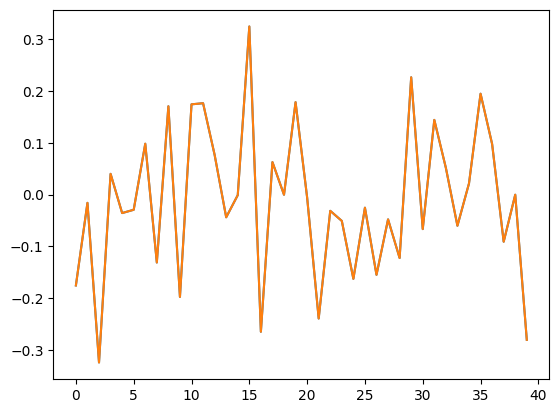

In [6]:
plt.plot(sol)
plt.plot(lstsq_sol)
plt.show()

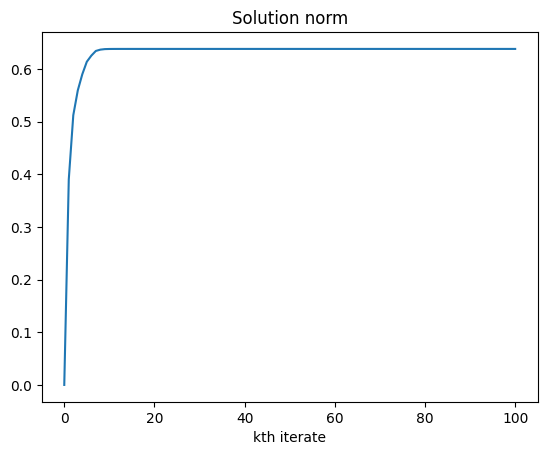

In [6]:
plt.plot(data["x_norms"])
plt.title("Solution norm")
plt.xlabel("kth iterate")
plt.show()

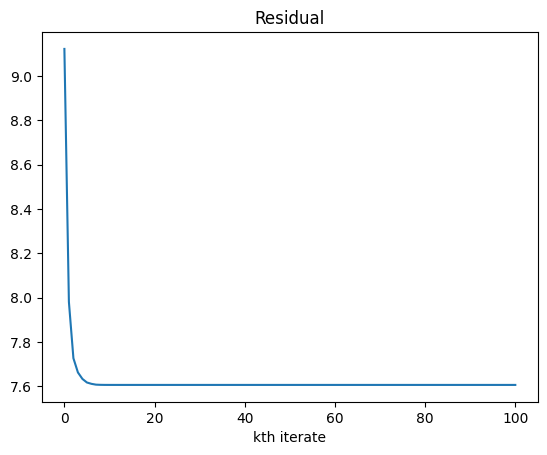

In [7]:
plt.plot(data["residual_norms"])
plt.title("Residual")
plt.xlabel("kth iterate")
plt.show()

# Tikhonov regularization

In [93]:
def cgls_regularized_least_squares(A, b, lam=1.0, *args, **kwargs):
    """Solves the regularized least-squares problem
    min_x || A x - b ||_2^2 + lam*|| x - z ||_2^2
    using a CGLS method.
    """
    # Build Atilde
    device = A.device
    xp = jlinops.device_to_module(device)
    n = A.shape[1]
    Atilde = jlinops.StackedOperator([A, np.sqrt(lam)*jlinops.IdentityOperator((n,n), device=device)])
    zeros = xp.zeros(n)
    rhs = xp.hstack([b, zeros])
    data = cgls(Atilde, rhs, *args, **kwargs)
    return data

In [94]:
n = 40
m = 100
A = np.random.normal(size=(m,n))
A = A
A = jlinops.MatrixLinearOperator(A)
# A, _ = jlinops.fixed_rank_tsvd(A, k=5)
b = np.random.normal(size=m)

In [95]:
data = regularized_least_squares(A, b, lam=1.0)

In [96]:
from scipy.sparse.linalg import cg

In [97]:
lam = 10.0
Q = (A.T @ A) + lam*jlinops.IdentityOperator((n,n))
scipy_cg_sol, _ = cg(Q, A.T @ b)

In [98]:
for lam in [1e-3, 1e-1, 1.0, 10.0, 100.0, 1000.0, 1e5]:
    
    data = regularized_least_squares(A, b, lam=lam)
    Q = (A.T @ A) + lam*jlinops.IdentityOperator((n,n))
    scipy_cg_sol, _ = cg(Q, A.T @ b)
    print(np.linalg.norm(data["x"] - scipy_cg_sol))

1.090777455275424e-05
1.0506801342410252e-05
7.520409015955583e-06
6.09171723907996e-06
1.5434584296917515e-06
2.4006546295671107e-07
1.662618874320236e-10


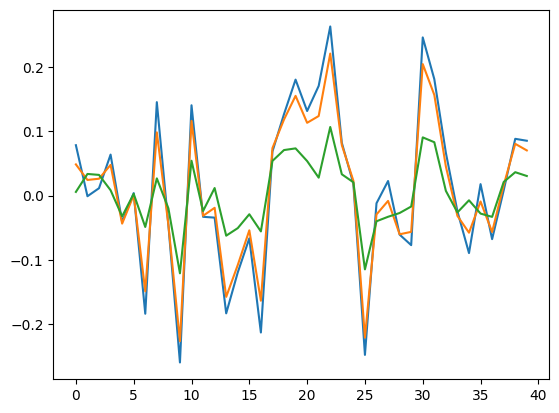

In [99]:
for lam in [1.0, 10.0, 100.0]:
    data = regularized_least_squares(A, b, lam=lam)
    plt.plot(data["x"])
plt.show()

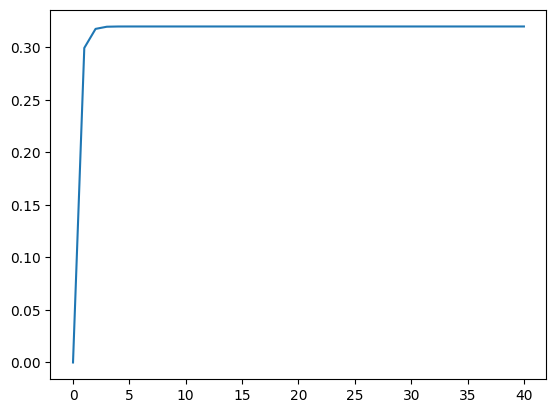

In [100]:
plt.plot(data["x_norms"])
plt.show()

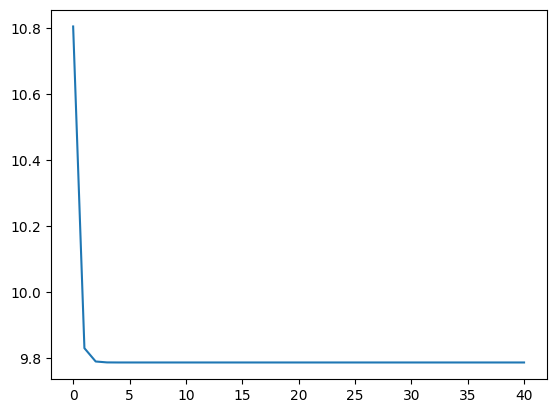

In [101]:
plt.plot(data["residual_norms"])
plt.show()

In [66]:
data = regularized_least_squares(A, b, lam=100, return_iterates=True)

In [70]:
fidelity_norms = []
for j in range(data["iterates"].shape[1]):
    fidelity_norms.append(np.linalg.norm(data["iterates"][:,j]))

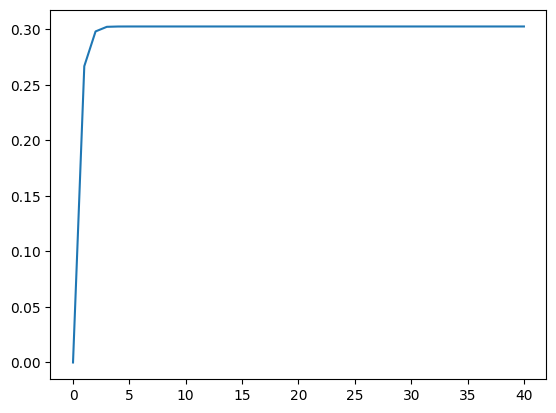

In [72]:
plt.plot(fidelity_norms)
plt.show()

In [75]:
data = cgls(A, b, maxiter=30, return_search_vectors=True)

In [84]:
W = data["search_vectors"]
W = W/np.linalg.norm(W, axis=0)

In [85]:
W.shape

(40, 31)

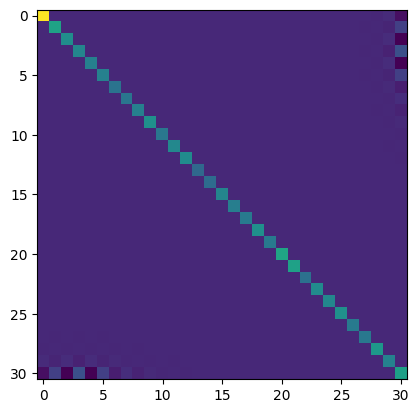

In [86]:
plt.imshow(W.T @ (A.T @ (A @ W)))
plt.show()

In [80]:
A.shape

(100, 40)

In [81]:
W.shape

(40, 31)

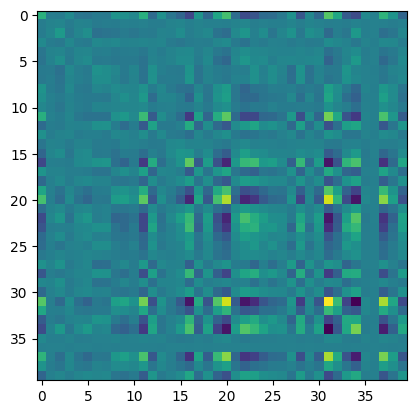

In [73]:
plt.imshow(W @ W.T)
plt.show()

# Bound constrained

In [53]:
def cgls_bounded(A, b, lam=1.0, x0=None, maxiter=None):
    """Estimates the solution to
    min_x || A x - b ||_2^2,  || x ||_2^2 <= lam,  \alpha^2 \leq || A^+ b ||_2^2.
    Performs CGLS until iterate violates the constraint (so does not necessarily solve
    the problem exactly. Note that it is also possible that the constraint is not active
    at the optimal value.
    """
    
    # If 
    device = A.device
    xp = jlinops.get_module(b)
    n = A.shape[1]
    
    # Initialization
    if x0 is None:
        x = xp.zeros(n)
    else:
        x = x0
        
    # Maxiter
    if maxiter is None:
        maxiter = n
            
    r_prev = b - A.matvec(x)
    At_r_prev = A.rmatvec(r_prev)
    d = A.rmatvec(r_prev)
    residual_norms = [xp.linalg.norm(r_prev)]
    x_norms = [xp.linalg.norm(x)]
    n_iters = 0
    for j in range(maxiter):
        
        # Compute iterate
        A_d = A.matvec(d) # only matvec with A
        alpha = (xp.linalg.norm(At_r_prev)/xp.linalg.norm(A_d))**2
        x = x + alpha*d
        r_curr = r_prev - alpha*A_d
        At_r_curr = A.rmatvec(r_curr) # only matvec with At
        beta = (xp.linalg.norm(At_r_curr)/xp.linalg.norm(At_r_prev))**2
        d = At_r_curr + beta*d
        
        # Advance
        r_prev = r_curr
        At_r_prev = At_r_curr
        n_iters += 1
        
        # Track residual and solution norm
        residual_norms.append(xp.linalg.norm(r_prev))
        x_norms.append(xp.linalg.norm(x))
        
        # Break?
        if (xp.linalg.norm(x)**2) > lam:
            break
        
    data = {
        "x": x,
        "residual_norms": xp.asarray(residual_norms),
        "x_norms": xp.asarray(x_norms),
    }
    
    return data
     

In [54]:
bounded_data = cgls_bounded(A, b, lam=1e-3)
bounded_sol = bounded_data["x"]

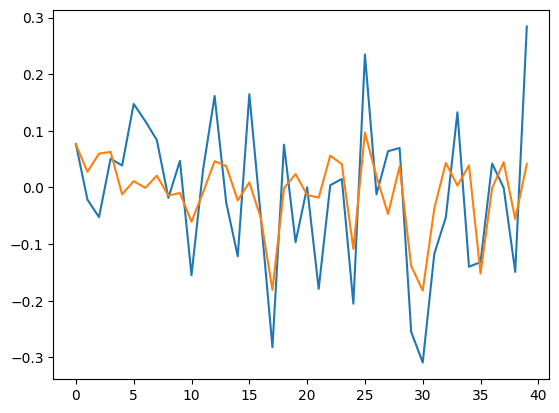

In [55]:
plt.plot(sol)
plt.plot(bounded_sol)
plt.show()

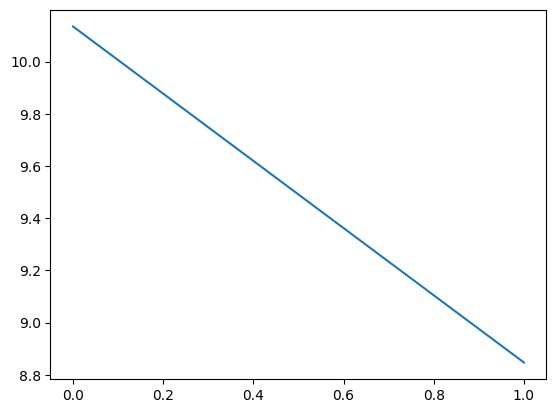

In [56]:
plt.plot(bounded_data["residual_norms"])
plt.show()